In [44]:
%load_ext autoreload
%autoreload 2
import logging
import argparse
import os
import numpy as np
import torch
import time
from ppnp.pytorch import PPNP, PPRGCN
from ppnp.pytorch.training import train_model
from ppnp.pytorch.earlystopping import stopping_args
from ppnp.pytorch.propagation import PPRExact, PPRPowerIteration, DiffusionIteration, PrePPRIteration
from ppnp.data.io import load_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
logging.basicConfig(
        format='%(asctime)s: %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S',
        level=logging.INFO + 2)

# PyTorch variant
This is not the official code that should be used to reproduce the results from the paper (see `reproduce_results.ipynb` for this), but an adaptation of that code to PyTorch for better accessibility. This notebook reproduces the accuracy of the TensorFlow implementation, but has a longer computation time and varies in some details due to the change to PyTorch.

# Load dataset

In [46]:
graph_name = 'pubmed' # cora_ml, citeseer, ms_academic, pubmed
graph = load_dataset(graph_name)
graph.standardize(select_lcc=True)

<Undirected, unweighted and connected SparseGraph with 88648 edges (no self-loops). Data: adj_matrix (19717x19717), attr_matrix (19717x500), labels (19717)>

from pathlib import Path
import pickle
import sys
sys.path.append('../gnn-untitled/')

data_dir = Path('../gnn-untitled/pprie/data')
graph_name = 'cora_ml_2c.SG'
path_to_file = data_dir / graph_name

with open(path_to_file, 'rb') as f:
    new_graph = pickle.load(f)
new_graph    

# Set up data splits

First of all we need to decide whether to use the test or validation set. Be mindful that we can only look at the test set exactly _once_ and then can't change any hyperparameters oder model details, no matter what. Everything else would cause overfitting.

In [47]:
test = True

These are the seeds for the dataset splits used in the paper for test/validation.

In [69]:

# test_seeds = [
#         2144199730,  794209841, 2985733717, 2282690970, 1901557222,
#         2009332812, 2266730407,  635625077, 3538425002,  960893189,
#         497096336, 3940842554, 3594628340,  948012117, 3305901371,
#         3644534211, 2297033685, 4092258879, 2590091101, 1694925034]
# test_seeds = [2144199730, ]
test_seeds = [
        2144199730,  794209841, 2985733717, 2282690970, 1901557222,
        ]
val_seeds = [
        2413340114, 3258769933, 1789234713, 2222151463, 2813247115,
        1920426428, 4272044734, 2092442742, 841404887, 2188879532,
        646784207, 1633698412, 2256863076,  374355442,  289680769,
        4281139389, 4263036964,  900418539,  119332950, 1628837138]

if test:
    seeds = test_seeds
else:
    seeds = val_seeds

Now we can choose the remaining settings for the training/early stopping/validation(test) split. These are the ones chosen in the paper

In [49]:

if graph_name == 'microsoft_academic':
    nknown = 5000
else:
    nknown = 1500
    
idx_split_args = {'ntrain_per_class': 20, 'nstopping': 500, 'nknown': nknown}

# Set up propagation

Next we need to set up the proper pmropagation scheme. In the paper we've introduced the exact PPR propagation used in PPNP and the PPR power iteration propagation used in APPNP.

We use the hyperparameters from the paper.

In [50]:
%%time
if graph_name == 'microsoft_academic':
    alpha = 0.2
else:
    alpha = 0.1

# prop_ppnp = PPRExact(graph.adj_matrix, alpha=alpha)
# prop_appnp = PPRPowerIteration(graph.adj_matrix, alpha=alpha, niter=10)
# prop_ppnp_d = DiffusionIteration(graph.adj_matrix, niter=10)
prop_ppnp_pre = PrePPRIteration(graph.adj_matrix, alpha=alpha, niter=10)

CPU times: user 2min 40s, sys: 30.7 s, total: 3min 11s
Wall time: 3min 6s


# Choose model hyperparameters

Now we choose the hyperparameters. These are the ones used in the paper for all datasets.

Note that we choose the propagation for APPNP.

In [51]:
# model_args = {
#     'hiddenunits': [64],
#     'drop_prob': 0.5,
#     'propagation': prop_appnp}

model_args = {
    'hiddenunits': [64],
    'drop_prob': 0.5,
    'propagation': prop_ppnp_pre}

# model_args = {
#     'adj_matrix': graph.adj_matrix,
#     'hiddenunits': [64],
#     'drop_prob': 0.5,
#     'niter': 10,
#     'alpha': alpha
# }

reg_lambda = 5e-3
learning_rate = 0.01

# Train model

First we set the remaining settings for training.

In [52]:
niter_per_seed = 1
save_result = False
print_interval = 10
device = 'cuda'

We use 20 different seeds for splitting and 5 iterations (different random initializations) per split, so we train 100 times altogether. This will take a while.

In [76]:
%%time
results = []
niter_tot = niter_per_seed * len(seeds)
i_tot = 0
for seed in seeds:
    idx_split_args['seed'] = seed
    for _ in range(niter_per_seed):
        i_tot += 1
        logging_string = f"Iteration {i_tot} of {niter_tot}"
        logging.log(22, "                     " + '-' * len(logging_string) + '\n' + logging_string)
        model, result = train_model(
            graph_name, PPNP, graph, model_args, learning_rate, reg_lambda,
            idx_split_args, stopping_args, test, device, None, print_interval)
        results.append({})
        results[-1]['stopping_accuracy'] = result['early_stopping']['accuracy']
        results[-1]['valtest_accuracy'] = result['valtest']['accuracy']
        results[-1]['runtime'] = result['runtime']
        results[-1]['runtime_perepoch'] = result['runtime_perepoch']
        results[-1]['split_seed'] = seed
        


2020-05-29 23:09:00:                      ----------------
Iteration 1 of 5
2020-05-29 23:09:01: PyTorch seed: 4192090559
2020-05-29 23:10:27: Last epoch: 826, best epoch: 628 (86.127 sec)
2020-05-29 23:10:27: Test accuracy: 80.0%
2020-05-29 23:10:27:                      ----------------
Iteration 2 of 5
2020-05-29 23:10:27: PyTorch seed: 3377225247
2020-05-29 23:11:27: Last epoch: 575, best epoch: 451 (60.012 sec)
2020-05-29 23:11:28: Test accuracy: 75.2%
2020-05-29 23:11:28:                      ----------------
Iteration 3 of 5
2020-05-29 23:11:28: PyTorch seed: 1220983297
2020-05-29 23:12:50: Last epoch: 772, best epoch: 672 (81.677 sec)
2020-05-29 23:12:50: Test accuracy: 77.9%
2020-05-29 23:12:50:                      ----------------
Iteration 4 of 5
2020-05-29 23:12:50: PyTorch seed: 53636996
2020-05-29 23:14:27: Last epoch: 930, best epoch: 830 (96.437 sec)
2020-05-29 23:14:27: Test accuracy: 77.9%
2020-05-29 23:14:27:                      ----------------
Iteration 5 of 5
20

CPU times: user 5min 51s, sys: 1min 31s, total: 7min 23s
Wall time: 7min 8s


## forward computation time

In [39]:
%%time
# from ppnp.preprocessing import normalize_attributes
# from ppnp.pytorch.training import get_predictions
# from ppnp.pytorch.utils import matrix_to_torch

# labels_all = graph.labels
# attr_mat_norm_np = normalize_attributes(graph.attr_matrix)
# attr_mat_norm = matrix_to_torch(attr_mat_norm_np).to(device)

# nfeatures = graph.attr_matrix.shape[1]
# nclasses = max(labels_all) + 1



CPU times: user 701 ms, sys: 74.6 ms, total: 776 ms
Wall time: 105 ms


In [228]:
# model_args = {
#     'hiddenunits': [64],
#     'drop_prob': 0.5,
#     'propagation': prop_ppnp_pre}
# model = PPNP(nfeatures, nclasses, **model_args).to(device)
model.propagation = prop_ppnp_pre

In [241]:

%time res = get_predictions(model, attr_mat_norm, torch.arange(len(labels_all)))


CPU times: user 24.6 ms, sys: 128 µs, total: 24.7 ms
Wall time: 23.7 ms


In [242]:
# model_args = {
#     'hiddenunits': [64],
#     'drop_prob': 0.5,
#     'propagation': prop_appnp}
# model = PPNP(nfeatures, nclasses, **model_args).to(device)
model.propagation = prop_appnp

In [251]:

%time res = get_predictions(model, attr_mat_norm, torch.arange(len(labels_all)))


CPU times: user 35.7 ms, sys: 0 ns, total: 35.7 ms
Wall time: 34.9 ms


# Evaluation

To evaluate the data we use Pandas and Seaborn (for bootstrapping).

In [77]:
import pandas as pd
import seaborn as sns

In [78]:
result_df = pd.DataFrame(results)
result_df.head(10)

,stopping_accuracy,valtest_accuracy,runtime,runtime_perepoch,split_seed
0,0.808,0.799693,86.127265,0.104144,2144199730
1,0.778,0.752374,60.012354,0.104188,794209841
2,0.796,0.778723,81.676673,0.105662,2985733717
3,0.764,0.778723,96.437053,0.103584,2282690970
4,0.798,0.795301,101.314267,0.106311,1901557222


The standard deviation doesn't really say much about the uncertainty of our results and the standard error of the mean (SEM) assumes a normal distribution. So the best way to get a valid estimate for our results' uncertainty is via bootstrapping.

In [79]:
def calc_uncertainty(values: np.ndarray, n_boot: int = 1000, ci: int = 95) -> dict:
    stats = {}
    stats['mean'] = values.mean()
    boots_series = sns.algorithms.bootstrap(values, func=np.mean, n_boot=n_boot)
    stats['CI'] = sns.utils.ci(boots_series, ci)
    stats['uncertainty'] = np.max(np.abs(stats['CI'] - stats['mean']))
    return stats

In [80]:
stopping_acc = calc_uncertainty(result_df['stopping_accuracy'])
valtest_acc = calc_uncertainty(result_df['valtest_accuracy'])
runtime = calc_uncertainty(result_df['runtime'])
runtime_perepoch = calc_uncertainty(result_df['runtime_perepoch'])

In [81]:
print("APPNP\n"
      "Early stopping: Accuracy: {:.2f} ± {:.2f}%\n"
      "{}: Accuracy: {:.2f} ± {:.2f}%\n"
      "Runtime: {:.3f} ± {:.3f} sec, per epoch: {:.2f} ± {:.2f}ms"
      .format(
          stopping_acc['mean'] * 100,
          stopping_acc['uncertainty'] * 100,
          'Test' if test else 'Validation',
          valtest_acc['mean'] * 100,
          valtest_acc['uncertainty'] * 100,
          runtime['mean'],
          runtime['uncertainty'],
          runtime_perepoch['mean'] * 1e3,
          runtime_perepoch['uncertainty'] * 1e3,
      ))

APPNP
Early stopping: Accuracy: 78.88 ± 1.52%
Test: Accuracy: 78.10 ± 1.39%
Runtime: 85.114 ± 14.655 sec, per epoch: 104.78 ± 0.97ms


original:
APPNP
Early stopping: Accuracy: 80.40 ± 0.00%
Test: Accuracy: 82.90 ± 0.00%
Runtime: 62.598 ± 0.000 sec, per epoch: 41.29 ± 0.00ms

re-run:
APPNP
Early stopping: Accuracy: 81.23 ± 0.42%
Test: Accuracy: 83.60 ± 0.32%
Runtime: 71.608 ± 2.747 sec, per epoch: 42.81 ± 0.37ms

ppnp_d:
A is symmatric, niter=6
APPNP
Early stopping: Accuracy: 77.94 ± 0.59%
Test: Accuracy: 79.70 ± 0.45%
Runtime: 3.912 ± 0.358 sec, per epoch: 20.55 ± 0.15ms

ppnp_d:
A is symmatric, niter=10
APPNP
Early stopping: Accuracy: 78.37 ± 0.62%
Test: Accuracy: 80.38 ± 0.50%
Runtime: 4.173 ± 0.235 sec, per epoch: 21.68 ± 0.12ms

ppnp_pre:
pre-compute PPR matrix (iterative), niter=10
APPNP
Early stopping: Accuracy: 81.34 ± 0.41%
Test: Accuracy: 83.74 ± 0.30%
Runtime: 32.504 ± 1.218 sec, per epoch: 19.06 ± 0.11ms

ppnp_pre:
pre-compute PPR matrix (iterative), niter=20
APPNP
Early stopping: Accuracy: 81.34 ± 0.39%
Test: Accuracy: 83.74 ± 0.33%
Runtime: 32.048 ± 1.240 sec, per epoch: 18.94 ± 0.10ms

PPRGCN:
APPNP
Early stopping: Accuracy: 80.95 ± 0.46%
Test: Accuracy: 83.38 ± 0.32%
Runtime: 25.545 ± 1.067 sec, per epoch: 18.63 ± 0.07ms


# Boosted PPNP与APPNP的training time对比

In [82]:
import matplotlib.pyplot as plt
print(plt.style.available)
plt.style.use('seaborn-whitegrid')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


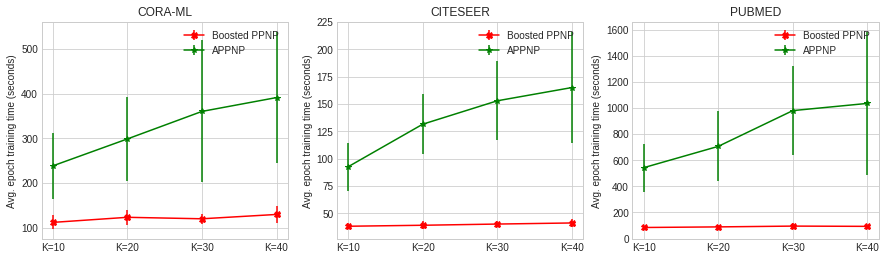

In [106]:
# def plot_single(axes, x, y, yerr):
#     axes.errorbar(x, y, yerr=yerr, label)


fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].errorbar([1, 2, 3, 4], [112.1, 123.5, 120.2, 129.9], yerr=[15.7, 16.5, 10.6, 18.4], label='Boosted PPNP', color='red', marker='X')
axes[0].errorbar([1, 2, 3, 4], [238.6, 298.9, 360.5, 391.5], yerr=[73.4, 93.9, 158.9, 147.3], label='APPNP', color='green', marker='*')
axes[0].set_xticks([1, 2, 3, 4])
axes[0].set_xticklabels(['K=10', 'K=20', 'K=30', 'K=40'])
axes[0].set_title('CORA-ML')
axes[0].set_ylabel('Avg. epoch training time (seconds)')
axes[0].legend()


axes[1].errorbar([1, 2, 3, 4], [38.3, 39.2, 40.3, 41.3], yerr=[2.8, 3.8, 2.6, 3.9], label='Boosted PPNP', color='red', marker='X')
axes[1].errorbar([1, 2, 3, 4], [92.7, 131.6, 153.0, 165.1], yerr=[21.9, 27.4, 36.2, 51.0], label='APPNP', color='green', marker='*')
axes[1].set_xticks([1, 2, 3, 4])
axes[1].set_xticklabels(['K=10', 'K=20', 'K=30', 'K=40'])
axes[1].set_title('CITESEER')
axes[1].set_ylabel('Avg. epoch training time (seconds)')
axes[1].legend()

axes[2].errorbar([1, 2, 3, 4], [85.1, 89.7, 95.8, 93.8], yerr=[14.7, 17.7, 20.4, 7.4], label='Boosted PPNP', color='red', marker='X')
axes[2].errorbar([1, 2, 3, 4], [542.8, 706.1, 979.9, 1035.1], yerr=[183.8, 268.7, 339.9, 548.6], label='APPNP', color='green', marker='*')
axes[2].set_xticks([1, 2, 3, 4])
axes[2].set_xticklabels(['K=10', 'K=20', 'K=30', 'K=40'])
axes[2].set_title('PUBMED')
axes[2].set_ylabel('Avg. epoch training time (seconds)')
axes[2].legend()


In [107]:
fig.savefig('running_time.pdf', bbox_inches='tight')